In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.deterministic import Fourier
from time import time
from sklearn.linear_model import Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

# from xgboost import XGBRegressor
import sys
sys.path.insert(0,'C:/users/stone/anaconda3/envs/env1/lib/site-packages')
from datetime import timedelta
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

<h3>Steps to be followed</h3>
<ol>
    <li>Read in data</li>
    <li>Find starting and ending dates for train and test sets</li>
    <li>Create date range containing all dates from start to end of training set with hourly frequency</li>
    <li>Create a feature for time data with hourly frequency</li>
    <li>Create lag features</li>
</ol>

<h4>Reading Dataset</h4>

In [2]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

train.date=pd.to_datetime(train.date)
test.date=pd.to_datetime(test.date)

<h4>Sorting train data by date and hour</h4>

In [3]:
train=train.sort_values(by=['date','hour'])
display(train.head())
print('train-shape: ',train.shape)
display(test.head())
print('test-shape: ',test.shape)

,date,hour,demand
0,2018-08-18,9,91
1,2018-08-18,10,21
2,2018-08-18,13,23
3,2018-08-18,14,104
4,2018-08-18,15,81


train-shape:  (18247, 3)


,date,hour
0,2021-03-01,0
1,2021-03-01,1
2,2021-03-01,2
3,2021-03-01,3
4,2021-03-01,5


test-shape:  (7650, 2)


<h4>Finding starting and ending dates for train and test sets</h4>

In [4]:
for title,df in [('Train',train),('Test',test)]:
    print(title+'\n'+'--'*30)
    print('Starting-date: ',df['date'].min())
    print('Ending-date: ',df['date'].max())
    print('\n')

Train
------------------------------------------------------------
Starting-date:  2018-08-18 00:00:00
Ending-date:  2021-02-28 00:00:00


Test
------------------------------------------------------------
Starting-date:  2021-03-01 00:00:00
Ending-date:  2022-03-28 00:00:00




In [5]:
# Generating hourly daterange for training data with hourly frequency
df1=pd.DataFrame({'combined_date':pd.date_range(start='2018-08-18',end='2021-02-28',freq='H')})

In [6]:
# merging hour column and datetime column
train['combined_date']=train.date.apply(lambda x:str(x))+' '+train.hour.apply(lambda x:str(x))+':00:00'
test['combined_date']=test.date.apply(lambda x:str(x))+' '+test.hour.apply(lambda x:str(x))+':00:00'

# converting new combined date column to datetime
train['combined_date']=pd.to_datetime(train['combined_date'])
test['combined_date']=pd.to_datetime(test['combined_date'])


In [7]:
# Merging df1 with train to get the full time index
df_train=pd.merge(df1,train,on='combined_date',how='left').drop(['date','hour'],axis=1).set_index('combined_date')
del(df1)

# filling NaN values with 0 since all missing timestamps can be assumed to have zero demand
df_train=df_train.fillna(0)

display(df_train.head())
print(df_train.shape)

,demand
combined_date,
2018-08-18 00:00:00,0.0
2018-08-18 01:00:00,0.0
2018-08-18 02:00:00,0.0
2018-08-18 03:00:00,0.0
2018-08-18 04:00:00,0.0


(22201, 1)


<h4>Creating fourier terms to capture seasonality</h4>

In [8]:
# creating a new time feature from the combined date column
dp=DeterministicProcess(index=df_train.index,
                       constant=False,
                       order=1,
                    additional_terms=[Fourier(period=12,order=1),
                                      Fourier(period=24,order=2)],
                       drop=True)
df1=dp.in_sample().rename(columns={'trend':'time1'})
df_train=pd.merge(df1,df_train,on='combined_date',how='inner')
df_train.tail()

,time1,"sin(1,12)","cos(1,12)","sin(1,24)","cos(1,24)",demand
combined_date,,,,,,
2021-02-27 20:00:00,22197.0,-8.660254e-01,-5.000000e-01,-8.660254e-01,0.500000,139.0
2021-02-27 21:00:00,22198.0,-1.000000e+00,4.191331e-13,-7.071068e-01,0.707107,112.0
2021-02-27 22:00:00,22199.0,-8.660254e-01,5.000000e-01,-5.000000e-01,0.866025,57.0
2021-02-27 23:00:00,22200.0,-5.000000e-01,8.660254e-01,-2.588190e-01,0.965926,66.0
2021-02-28 00:00:00,22201.0,-3.252216e-13,1.000000e+00,-1.626108e-13,1.000000,108.0


In [9]:
df1=dp.out_of_sample(test.shape[0]).set_index(test.combined_date).rename(columns={'trend':'time1'})
df_test=pd.merge(df1,test,on='combined_date',how='inner')
df_test.drop(['date','hour'],axis=1,inplace=True)
df_test.head()

,combined_date,time1,"sin(1,12)","cos(1,12)","sin(1,24)","cos(1,24)"
0,2021-03-01 00:00:00,22202.0,0.500000,8.660254e-01,0.258819,0.965926
1,2021-03-01 01:00:00,22203.0,0.866025,5.000000e-01,0.500000,0.866025
2,2021-03-01 02:00:00,22204.0,1.000000,1.069576e-12,0.707107,0.707107
3,2021-03-01 03:00:00,22205.0,0.866025,-5.000000e-01,0.866025,0.500000
4,2021-03-01 05:00:00,22206.0,0.500000,-8.660254e-01,0.965926,0.258819


#### Plotting demand to visualize Data

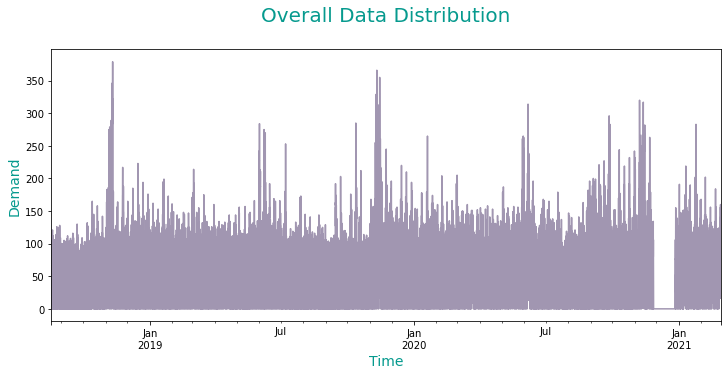

In [10]:
df_train['demand'].plot(figsize=(12,5),alpha=0.75,color='#827397')

# Setting title
plt.title('Overall Data Distribution\n',fontdict={'fontsize':20,'fontweight':5,'color':'#069A8E'})

# setting xlabels and ylabels
plt.xlabel('Time',fontdict={'fontsize':14,'fontweight':5,'color':'#069A8E'})
plt.ylabel('Demand',fontdict={'fontsize':14,'fontweight':5,'color':'#069A8E'});

It looks like data for the month of December,2020 is missing

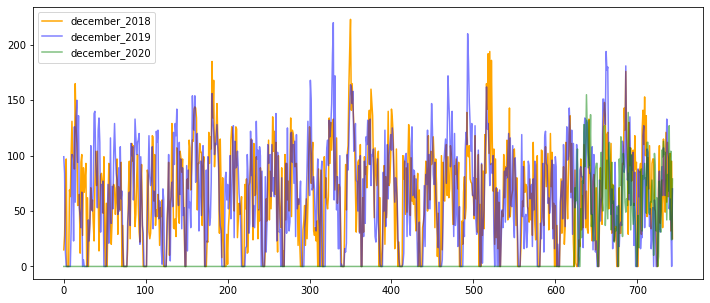

In [11]:
# Plotting data for december for 3 years
december_2018=df_train.loc[(df_train.index.year==2018) &(df_train.index.month==12)].reset_index()
december_2019=df_train.loc[(df_train.index.year==2019) &(df_train.index.month==12)].reset_index()
december_2020=df_train.loc[(df_train.index.year==2020) &(df_train.index.month==12)].reset_index()

december_2018['demand'].plot(figsize=(12,5),label='december_2018',color='orange')
december_2019['demand'].plot(figsize=(12,5),label='december_2019',color='blue',alpha=0.5)
december_2020['demand'].plot(figsize=(12,5),label='december_2020',color='green',alpha=0.5)


plt.legend();

December,2020 has missing data from 2020-12-01 to 2020-12-26. So these values will be replaced by average values from previous years

In [12]:
# Imputing missing values in december 2020 with average values from previous years

imputed_demand=0.5*(df_train.loc['2018-12-01':'2018-12-26','demand'].values+\
                    df_train.loc['2019-12-01':'2019-12-26','demand'].values)

df_train.loc['2020-12-01':'2020-12-26','demand']=imputed_demand

<AxesSubplot:xlabel='combined_date'>

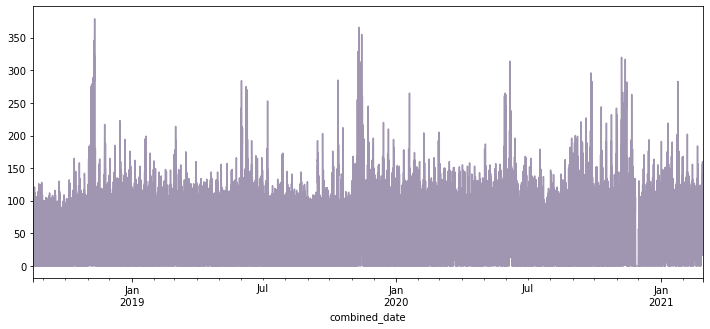

In [13]:
# Plotting the corrected data
df_train['demand'].plot(figsize=(12,5),alpha=0.75,color='#827397')

In [14]:
df_test.set_index('combined_date',inplace=True)
print('Done!')

Done!


<h4>Creating Lag Features</h4>

In [15]:
def make_lags(df,col_names,n_lags=20):
    '''
    Creates lag_features from a list of features for a data frame
    
    Inputs
    ------------------------------
    df- the daataframe
    col_name--list of strings indicating column names from which features need to be created
    n_lags: number of lags to be created
    
    Outputs
    ------------------------------
    consolidated dataframe containing the lag features
    '''
    
    data=df.copy(deep=True)
    
    for col in col_names:
        for i in range(1,n_lags+1):
            data.loc[:,col+'_lag_'+str(i)]=data[col].shift(i)
    
    # fill NaN values with 0
    data.fillna(0,inplace=True)
    return data

def make_leads(df,col_names,n_leads=5):
    '''
    Creates lead_features from a list of features for a data frame
    
    Inputs
    ------------------------------
    df- the daataframe
    col_name--list of strings indicating column names from which features need to be created
    n_lags: number of lags to be created
    
    Outputs
    ------------------------------
    consolidated dataframe containing the lead features
    '''
    data=df.copy(deep=True)
    
    for col in col_names:
        for i in range(1,n_leads+1):
            data.loc[:,col+'_lead_'+str(i)]=data[col].shift(-i)
            
    return data

#### Creating Features

In [16]:
df_train['log10_time']=df_train['time1'].apply(lambda x:np.log10(1+x))
df_train.drop('time1',axis=1,inplace=True)
df_train.head()

,"sin(1,12)","cos(1,12)","sin(1,24)","cos(1,24)",demand,log10_time
combined_date,,,,,,
2018-08-18 00:00:00,0.000000,1.000000e+00,0.000000,1.000000,0.0,0.301030
2018-08-18 01:00:00,0.500000,8.660254e-01,0.258819,0.965926,0.0,0.477121
2018-08-18 02:00:00,0.866025,5.000000e-01,0.500000,0.866025,0.0,0.602060
2018-08-18 03:00:00,1.000000,6.123234e-17,0.707107,0.707107,0.0,0.698970
2018-08-18 04:00:00,0.866025,-5.000000e-01,0.866025,0.500000,0.0,0.778151


#### Creating lags

In [17]:
num_lags=30
df_train1=make_lags(df_train,['demand'],n_lags=num_lags)

df_train1.drop('demand',axis=1,inplace=True)
df_train1.head()

,"sin(1,12)","cos(1,12)","sin(1,24)","cos(1,24)",log10_time,demand_lag_1,demand_lag_2,demand_lag_3,demand_lag_4,demand_lag_5,...,demand_lag_21,demand_lag_22,demand_lag_23,demand_lag_24,demand_lag_25,demand_lag_26,demand_lag_27,demand_lag_28,demand_lag_29,demand_lag_30
combined_date,,,,,,,,,,,,,,,,,,,,,
2018-08-18 00:00:00,0.000000,1.000000e+00,0.000000,1.000000,0.301030,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-08-18 01:00:00,0.500000,8.660254e-01,0.258819,0.965926,0.477121,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-08-18 02:00:00,0.866025,5.000000e-01,0.500000,0.866025,0.602060,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-08-18 03:00:00,1.000000,6.123234e-17,0.707107,0.707107,0.698970,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-08-18 04:00:00,0.866025,-5.000000e-01,0.866025,0.500000,0.778151,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
num_leads=765
Y=df_train.iloc[:,4:5]
Y1=make_leads(Y,['demand'],n_leads=num_leads).dropna()
display(Y1.tail())
print(Y1.shape)

,demand,demand_lead_1,demand_lead_2,demand_lead_3,demand_lead_4,demand_lead_5,demand_lead_6,demand_lead_7,demand_lead_8,demand_lead_9,...,demand_lead_756,demand_lead_757,demand_lead_758,demand_lead_759,demand_lead_760,demand_lead_761,demand_lead_762,demand_lead_763,demand_lead_764,demand_lead_765
combined_date,,,,,,,,,,,,,,,,,,,,,
2021-01-26 23:00:00,0.0,25.0,32.0,14.0,0.0,36.0,53.0,43.0,101.0,42.0,...,88.0,160.0,120.0,125.0,109.0,73.0,116.0,142.0,58.0,139.0
2021-01-27 00:00:00,25.0,32.0,14.0,0.0,36.0,53.0,43.0,101.0,42.0,121.0,...,160.0,120.0,125.0,109.0,73.0,116.0,142.0,58.0,139.0,112.0
2021-01-27 01:00:00,32.0,14.0,0.0,36.0,53.0,43.0,101.0,42.0,121.0,40.0,...,120.0,125.0,109.0,73.0,116.0,142.0,58.0,139.0,112.0,57.0
2021-01-27 02:00:00,14.0,0.0,36.0,53.0,43.0,101.0,42.0,121.0,40.0,29.0,...,125.0,109.0,73.0,116.0,142.0,58.0,139.0,112.0,57.0,66.0
2021-01-27 03:00:00,0.0,36.0,53.0,43.0,101.0,42.0,121.0,40.0,29.0,52.0,...,109.0,73.0,116.0,142.0,58.0,139.0,112.0,57.0,66.0,108.0


(21436, 766)


In [19]:
X,y=df_train1.align(Y1,join='inner',axis=0)
print(X.shape)
print(y.shape)

(21436, 35)
(21436, 766)


In [20]:
X_train,y_train=X.iloc[:-766],y.iloc[:-766]
X_val,y_val=X.iloc[-766:],y.iloc[-766:]

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(20670, 35)
(766, 35)
(20670, 766)
(766, 766)


Total length of forecast horizon(test-set) is 7650. Need to train model which predicts 765 periods ahead. Final prediction to be predicted in 11 recursive steps

<h3>Model Building</h3>

<h4>Linear Model</h4>

In [ ]:
start=time()

lr_model=MultiOutputRegressor(Ridge(alpha=0.7,random_state=42))
lr_model.fit(X_train,y_train)
pred=lr_model.predict(X_val)

print(time()-start)

In [ ]:
ll=X_train.index[-1]
new_idx=pd.date_range(start=ll,periods=766,freq='H')+timedelta(hours=1)

pred1=pd.DataFrame(pred,columns=y_val.columns,index=new_idx)
row_pred=pd.Series(pred1.iloc[0,:].values,index=new_idx)

row_pred.plot(figsize=(12,5),label='pred',color='orange')
y_val['demand'].plot(label='original',color='blue',alpha=0.3)

print('validation_Root_mean_squared_error: ',np.sqrt(mean_squared_error(y_val['demand'],row_pred)))
plt.legend();

In [ ]:
# Refit the model on the entire dataset
start=time()
lr_model.fit(X,y)
print(time()-start)

#### Forecasting on unknown values

In [ ]:

X_ex=X.copy(deep=True)
orig_idx=X.index
y_ex=list(y['demand'].copy(deep=True).values)

ll=X.index[-1]+timedelta(hours=1)
new_ids=pd.date_range(start=ll,periods=766*14,freq='H')

col_1=['sin(1,12)','cos(1,12)','cos(1,24)','sin(1,24)','log10_time']
# generating fourier terms for the forecast range
dp=DeterministicProcess(index=new_ids,
                       constant=False,
                       order=1,
                    additional_terms=[Fourier(period=12,order=1),
                                      Fourier(period=24,order=2)],
                       drop=True)
df_fore=dp.in_sample()
df_fore['trend']+=21436
df_fore['log10_time']=np.log10(df_fore['trend'])
df_fore.drop('trend',axis=1,inplace=True)


## set loop variable here
for step in range(14):
    start,stop=0,1
    x1=df_fore.iloc[start:stop]

    # set lag values
    for lag in range(1,num_lags+1):
        x1.loc[idx,'demand_lag_'+str(lag)]=y_ex[-lag]

    # predict using x1
    y_ex.extend(list(np.ravel(lr_model.predict(x1))))

    start+=766
    stop+=766

# Generating date-time index 
idx1=list(orig_idx)+list(new_ids)

# generating final Predictions
y_final=pd.Series(y_ex,index=idx1)

In [ ]:
df_test,y_sub=df_test.align(y_final,join='inner',axis=0)

In [ ]:
df_test['date']=df_test.index.date
df_test['hour']=df_test.index.hour
df_test['demand']=y_sub
df_test.drop(['time1', 'sin(1,12)', 'cos(1,12)', 'sin(1,24)', 'cos(1,24)'],axis=1,inplace=True)
df_test.head()

In [ ]:
df_test.to_csv('submission_DiRec_ridge.csv',index=False)
print('Done!')

#### LightGBM Regressor

In [ ]:
start=time()


lgbm_params={'colsample_bytree': 0.6,
             'learning_rate': 0.01,
             'max_depth': 8,
             'min_child_samples': 20,
             'min_child_weight': 0.001,
             'n_estimators': 1000,
             'num_leaves': 2980}

base_lgbr=LGBMRegressor(**lgbm_params)

mult_lgbm=MultiOutputRegressor(base_lgbr)
mult_lgbm.fit(np.array(X_train),np.array(y_train))

print(time()-start)

validation_Root_mean_squared_error:  38.20851113583599


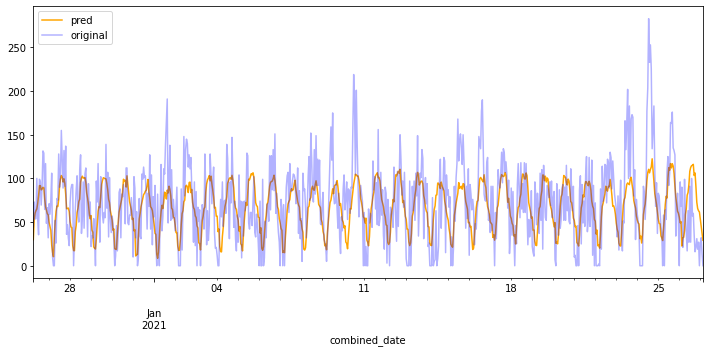

In [23]:
pred=mult_lgbm.predict(np.array(X_val))
ll=X_train.index[-1]
new_idx=pd.date_range(start=ll,periods=766,freq='H')+timedelta(hours=1)

pred1=pd.DataFrame(pred,columns=y_val.columns,index=new_idx)
row_pred=pd.Series(pred1.iloc[0,:].values,index=new_idx)

row_pred.plot(figsize=(12,5),label='pred',color='orange')
y_val['demand'].plot(label='original',color='blue',alpha=0.3)

print('validation_Root_mean_squared_error: ',np.sqrt(mean_squared_error(y_val['demand'],row_pred)))
plt.legend();

In [24]:
# Refit the model on the entire dataset
start=time()
mult_lgbm.fit(np.array(X),np.array(y))
print(time()-start)

[LightGBM] [Warning] Unknown parameter: gamma


KeyboardInterrupt: 

<h3>Forecasting</h3>

<h3>References</h3>
<ol>
    <li><a href='https://towardsdatascience.com/ml-time-series-forecasting-the-right-way-cbf3678845ff'>Forecasting the    right way</a></li>
    <li><a href='https://dzone.com/articles/lessons-learnt-while-solving-time-series-forecasti-1'>dzone-article</a></li>
</ol>